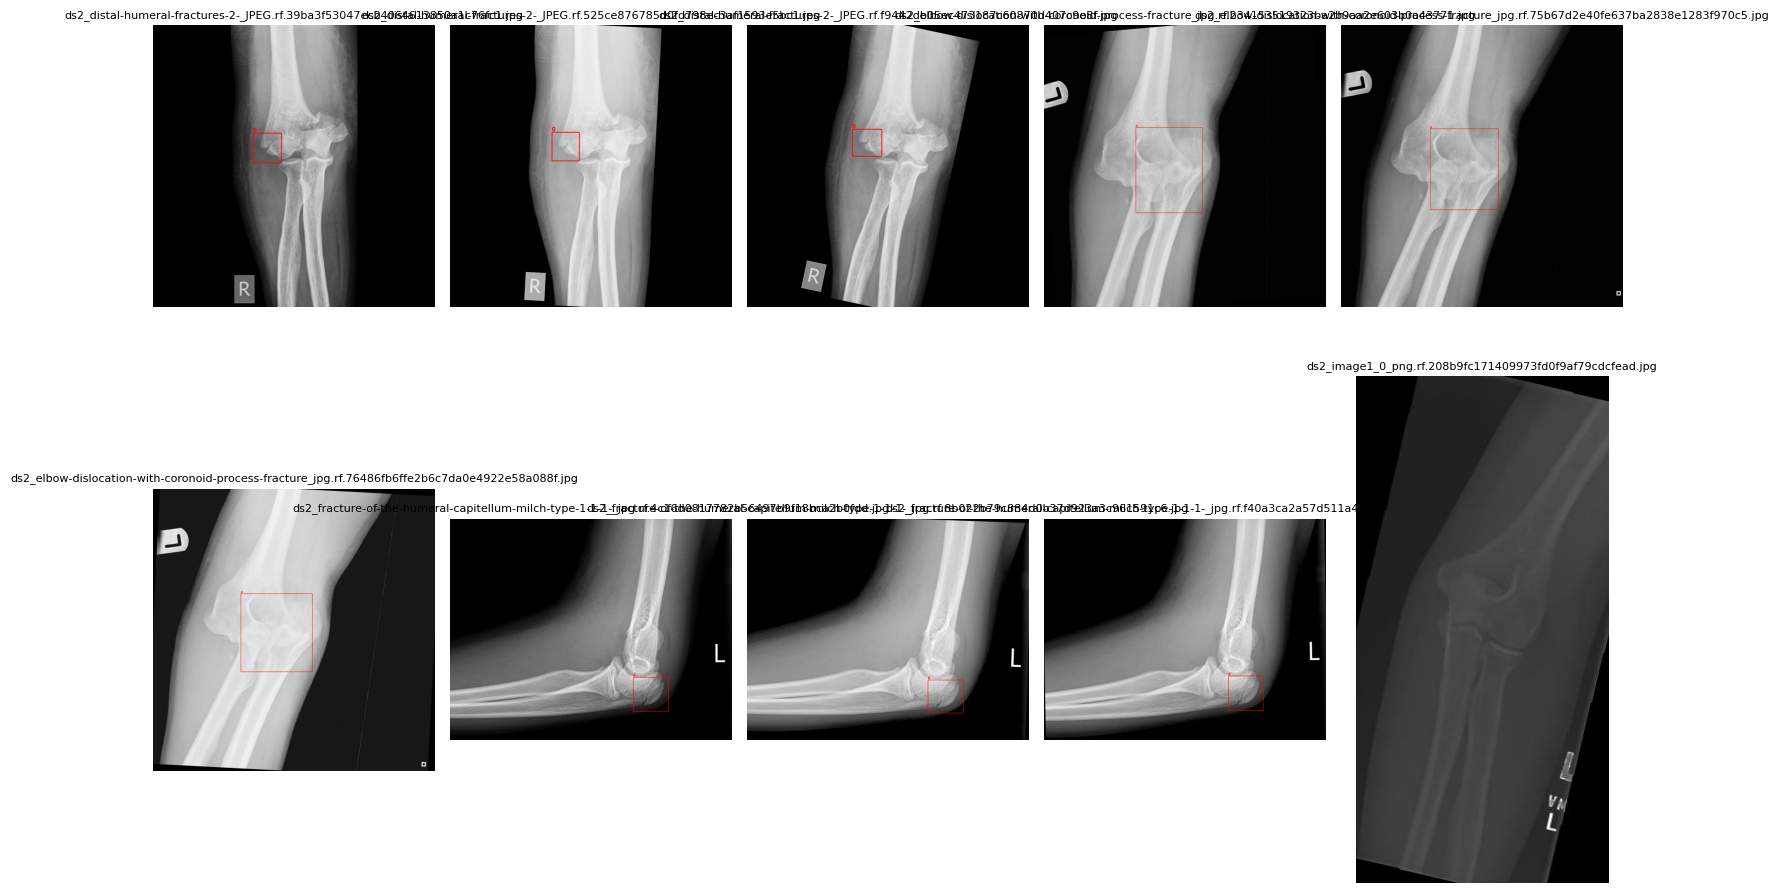

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_dir = "/kaggle/input/bone-fracture-merged-dataset/Merged/train/images"
label_dir = "/kaggle/input/bone-fracture-merged-dataset/Merged/train/labels"

files = sorted(os.listdir(image_dir))[:10]

plt.figure(figsize=(15, 10))

for i, file in enumerate(files):
    img_path = os.path.join(image_dir, file)
    label_path = os.path.join(
        label_dir,
        file.replace(".jpg", ".txt").replace(".png", ".txt")
    )

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                cls = int(parts[0])
                values = parts[1:]

                # ── YOLO box ─────────────────────────────
                if len(values) == 4:
                    x_c, y_c, bw, bh = values
                    x1 = int((x_c - bw / 2) * w)
                    y1 = int((y_c - bh / 2) * h)
                    x2 = int((x_c + bw / 2) * w)
                    y2 = int((y_c + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(
                        img, str(cls), (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2
                    )

                # ── Polygon (segmentation) ───────────────
                elif len(values) >= 6 and len(values) % 2 == 0:
                    xs = values[0::2]
                    ys = values[1::2]

                    pts = np.array(
                        [[int(x * w), int(y * h)] for x, y in zip(xs, ys)],
                        dtype=np.int32
                    )

                    cv2.polylines(img, [pts], True, (0, 255, 0), 2)

                    # optional: enclosing box
                    x1, y1 = pts.min(axis=0)
                    x2, y2 = pts.max(axis=0)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(file, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
!pip install -q ultralytics

In [6]:
from ultralytics import YOLO
model = YOLO('yolo12s.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
model.train(
    data="/kaggle/input/bone-fracture-merged-dataset/Merged/data.yaml",
    epochs=20,
    imgsz=768,        # lower resolution
    batch=16,         # smaller batch per GPU
    half=True,        # use FP16 to save memory
    augment=True,
    hsv_h=0.0,
    hsv_s=0.0,
    hsv_v=0.1,
    degrees=5,
    scale=0.2,
    translate=0.05,
    shear=1,
    cache="disk",     # avoid RAM cache
    mosaic=0.0,
    mixup=0.0,
    copy_paste=0.0
)


Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/bone-fracture-merged-dataset/Merged/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.0, hsv_s=0.0, hsv_v=0.1, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        476        361       0.67      0.623      0.657      0.314
        elbow positive         28         29      0.243      0.103      0.129     0.0342
      fingers positive         41         48          0          0      0.113     0.0362
      forearm fracture         37         43      0.686      0.442      0.456      0.189
               humerus         31         36        0.8      0.528      0.653      0.247
     shoulder fracture         19         20      0.171       0.05      0.134     0.0546
        wrist positive         17         28      0.242     0.0584      0.069     0.0311
            Comminuted         15         15      0.899      0.667       0.72      0.336
            Greenstick         10         10       0.75        0.6      0.501      0.233
               Healthy          7          7      0.872          1      0.995      0.608
                Linear          1          1       0.75          1      0.995      0.398
     Oblique Displace

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b2f6cd615d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044

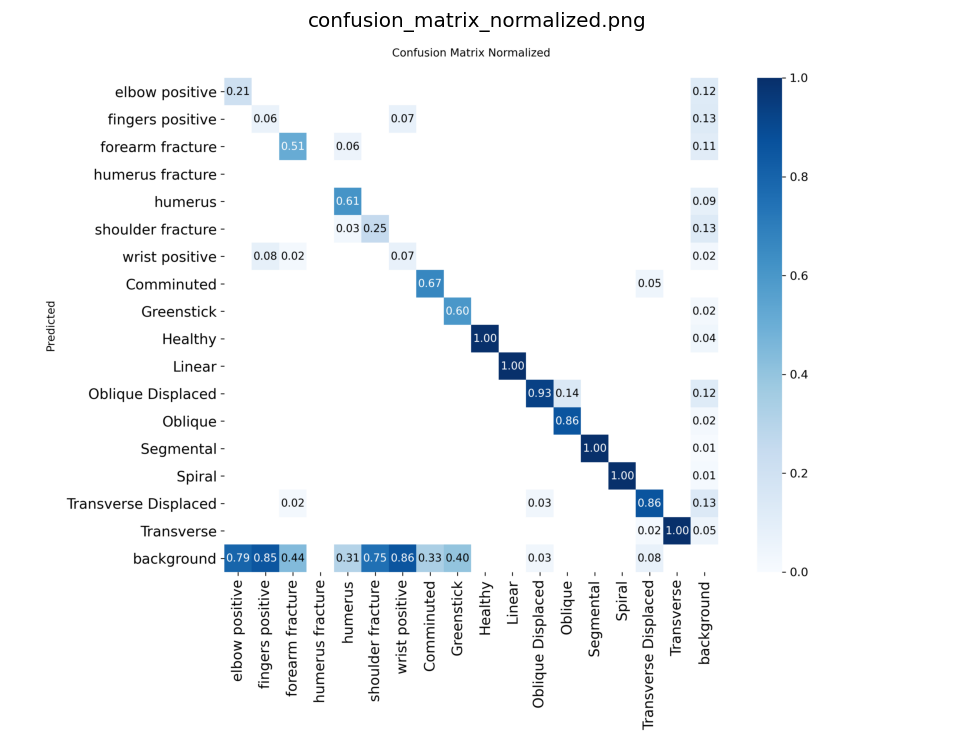

[HATA] Dosya bulunamadı: /kaggle/working/runs/detect/train/F1_curve.png
[HATA] Dosya bulunamadı: /kaggle/working/runs/detect/train/P_curve.png
[HATA] Dosya bulunamadı: /kaggle/working/runs/detect/train/R_curve.png
[HATA] Dosya bulunamadı: /kaggle/working/runs/detect/train/PR_curve.png


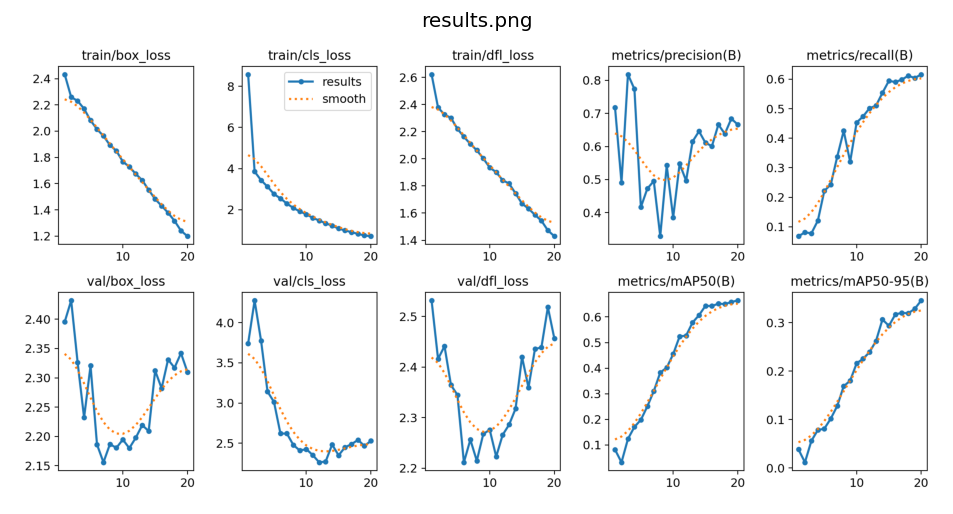

In [11]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images(post_training_files_path, image_files):
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)

        if not os.path.exists(image_path):
            print(f"[HATA] Dosya bulunamadı: {image_path}")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"[HATA] Görüntü okunamadı: {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = '/kaggle/working/runs/detect/train'

# Display the images
display_images(post_training_files_path, image_files)

In [9]:
# === Paths ===
VAL_IMAGE_DIR = "/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/valid/images"
MODEL_PATH    = "/kaggle/working/runs/detect/train/weights/best.pt"  # or wherever your model is

# === Load trained model ===
model = YOLO(MODEL_PATH)

In [10]:
# === Collect validation images ===
val_images = [os.path.join(VAL_IMAGE_DIR, f)
              for f in os.listdir(VAL_IMAGE_DIR)
              if f.lower().endswith((".png", ".jpg", ".jpeg"))]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/valid/images'

In [ ]:
import random
# === Sample  random images ===
sampled = random.sample(val_images, min(30, len(val_images)))

In [ ]:
# === Run inference ===
results = model(sampled)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
# === Plotting (6 rows × 4 columns) ===
fig, axes = plt.subplots(5, 6, figsize=(10, 20))
axes = axes.flatten()

for ax, result in zip(axes, results):
    img = result.orig_img  # NumPy image
    boxes = result.boxes

    ax.imshow(img, cmap="gray" if len(img.shape) == 2 or img.shape[2] == 1 else None)

    if boxes is not None and boxes.xyxy is not None:
        for box in boxes.xyxy.cpu().numpy():
            x1, y1, x2, y2 = box[:4]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor="lime", facecolor="none")
            ax.add_patch(rect)

    ax.set_title(os.path.basename(result.path), fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()